## Librerías

In [60]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator, HillClimbSearch, BicScore
from pgmpy.inference import VariableElimination
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError

## Dataset

In [61]:
test_df = pd.read_csv('dataset/student_addiction_dataset_test.csv')
train_df = pd.read_csv('dataset/student_addiction_dataset_train.csv')

In [62]:
test_df.shape, train_df.shape

((12744, 11), (50342, 11))

## Transformar valores

In [63]:
test_df.head()

,Experimentation,Academic_Performance_Decline,Social_Isolation,Financial_Issues,Physical_Mental_Health_Problems,Legal_Consequences,Relationship_Strain,Risk_Taking_Behavior,Withdrawal_Symptoms,Denial_and_Resistance_to_Treatment,Addiction_Class
0,Yes,Yes,Yes,No,Yes,No,No,No,Yes,No,No
1,No,No,Yes,No,No,Yes,No,Yes,No,No,No
2,No,No,No,Yes,No,Yes,No,No,Yes,No,No
3,Yes,No,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes
4,No,No,No,No,Yes,No,No,No,No,Yes,No


In [64]:
train_df.head()

,Experimentation,Academic_Performance_Decline,Social_Isolation,Financial_Issues,Physical_Mental_Health_Problems,Legal_Consequences,Relationship_Strain,Risk_Taking_Behavior,Withdrawal_Symptoms,Denial_and_Resistance_to_Treatment,Addiction_Class
0,Yes,No,No,Yes,No,No,No,Yes,No,No,No
1,No,Yes,NaN,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes
2,No,No,No,No,No,Yes,Yes,Yes,No,No,No
3,Yes,No,Yes,Yes,No,Yes,No,No,No,Yes,Yes
4,Yes,Yes,No,NaN,No,Yes,Yes,Yes,No,No,Yes


In [65]:
pd.set_option('future.no_silent_downcasting', True)
train_df = train_df.replace({'Yes': 1, 'No': 0})
test_df = test_df.replace({'Yes': 1, 'No': 0})

In [66]:
train_df.head()

,Experimentation,Academic_Performance_Decline,Social_Isolation,Financial_Issues,Physical_Mental_Health_Problems,Legal_Consequences,Relationship_Strain,Risk_Taking_Behavior,Withdrawal_Symptoms,Denial_and_Resistance_to_Treatment,Addiction_Class
0,1,0,0,1,0,0,0,1,0,0,0
1,0,1,NaN,1,1,1,1,1,1,0,1
2,0,0,0,0,0,1,1,1,0,0,0
3,1,0,1,1,0,1,0,0,0,1,1
4,1,1,0,NaN,0,1,1,1,0,0,1


In [67]:
test_df.head()

,Experimentation,Academic_Performance_Decline,Social_Isolation,Financial_Issues,Physical_Mental_Health_Problems,Legal_Consequences,Relationship_Strain,Risk_Taking_Behavior,Withdrawal_Symptoms,Denial_and_Resistance_to_Treatment,Addiction_Class
0,1,1,1,0,1,0,0,0,1,0,0
1,0,0,1,0,0,1,0,1,0,0,0
2,0,0,0,1,0,1,0,0,1,0,0
3,1,0,1,0,1,1,0,1,0,1,1
4,0,0,0,0,1,0,0,0,0,1,0


# Balanceo de Clases

In [68]:
test_df['Addiction_Class'].value_counts()

Addiction_Class
0    10105
1     2639
Name: count, dtype: int64

In [69]:
train_df['Addiction_Class'].value_counts()

Addiction_Class
0    35270
1    15072
Name: count, dtype: int64

# Analisis previo

In [70]:
train_df.describe()

,Experimentation,Academic_Performance_Decline,Social_Isolation,Financial_Issues,Physical_Mental_Health_Problems,Legal_Consequences,Relationship_Strain,Risk_Taking_Behavior,Withdrawal_Symptoms,Denial_and_Resistance_to_Treatment,Addiction_Class
count,47780,47844,47792,47805,47888,47766,47799,47765,47730,47889,50342
unique,2,2,2,2,2,2,2,2,2,2,2
top,1,1,1,1,0,0,1,0,1,1,0
freq,24017,23955,23898,23993,23986,23915,24010,23938,24058,24071,35270


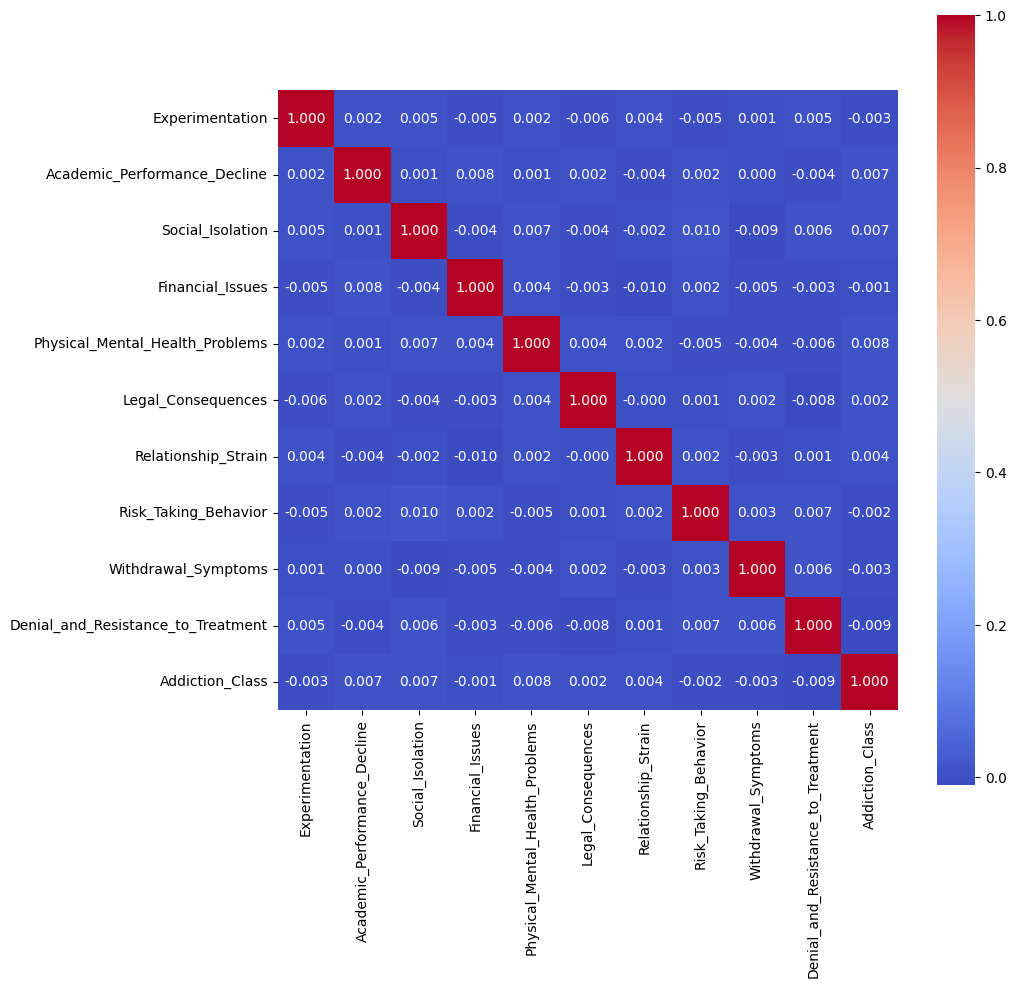

In [71]:
corr = train_df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, fmt=".3f", cmap='coolwarm', cbar=True, square=True)
plt.show()

# Redes Bayesianas Inicial

In [72]:
hc = HillClimbSearch(data=train_df)
best_model = hc.estimate(scoring_method=BicScore(train_df), show_progress=False)
for edge in best_model.edges():
    print(edge)

('Experimentation', 'Academic_Performance_Decline')
('Experimentation', 'Addiction_Class')
('Experimentation', 'Financial_Issues')
('Experimentation', 'Denial_and_Resistance_to_Treatment')
('Experimentation', 'Relationship_Strain')
('Experimentation', 'Physical_Mental_Health_Problems')
('Academic_Performance_Decline', 'Addiction_Class')
('Academic_Performance_Decline', 'Relationship_Strain')
('Academic_Performance_Decline', 'Physical_Mental_Health_Problems')
('Academic_Performance_Decline', 'Denial_and_Resistance_to_Treatment')
('Social_Isolation', 'Physical_Mental_Health_Problems')
('Social_Isolation', 'Relationship_Strain')
('Social_Isolation', 'Experimentation')
('Social_Isolation', 'Addiction_Class')
('Social_Isolation', 'Financial_Issues')
('Social_Isolation', 'Denial_and_Resistance_to_Treatment')
('Social_Isolation', 'Academic_Performance_Decline')
('Financial_Issues', 'Relationship_Strain')
('Financial_Issues', 'Denial_and_Resistance_to_Treatment')
('Financial_Issues', 'Physical

In [73]:
model = BayesianNetwork(best_model.edges())
model.fit(train_df, estimator=BayesianEstimator, prior_type="BDeu")
for cpd in model.get_cpds():
    print(cpd)

+----------------------+-----+-------------------------+
| Legal_Consequences   | ... | Legal_Consequences(1)   |
+----------------------+-----+-------------------------+
| Risk_Taking_Behavior | ... | Risk_Taking_Behavior(1) |
+----------------------+-----+-------------------------+
| Social_Isolation     | ... | Social_Isolation(1)     |
+----------------------+-----+-------------------------+
| Withdrawal_Symptoms  | ... | Withdrawal_Symptoms(1)  |
+----------------------+-----+-------------------------+
| Experimentation(0)   | ... | 0.5024790187217559      |
+----------------------+-----+-------------------------+
| Experimentation(1)   | ... | 0.497520981278244       |
+----------------------+-----+-------------------------+
+---------------------------------+-----+-------------------------+
| Experimentation                 | ... | Experimentation(1)      |
+---------------------------------+-----+-------------------------+
| Financial_Issues                | ... | Financial_Iss

In [74]:
inference = VariableElimination(model)

evidences = [
    {'Experimentation': 1, 'Academic_Performance_Decline': 1, 'Social_Isolation': 1, 'Financial_Issues': 1, 'Legal_Consequences': 1, 'Relationship_Strain': 1, 'Risk_Taking_Behavior': 1, 'Withdrawal_Symptoms': 1},
    {'Academic_Performance_Decline': 1, 'Relationship_Strain': 1, 'Physical_Mental_Health_Problems': 1, 'Legal_Consequences': 1, 'Risk_Taking_Behavior': 1},
    {'Risk_Taking_Behavior': 1, 'Withdrawal_Symptoms': 1, 'Denial_and_Resistance_to_Treatment': 1},
    {'Physical_Mental_Health_Problems': 1, 'Legal_Consequences': 1, 'Experimentation': 1, 'Social_Isolation': 1}
]

# Realizar inferencias
for i, evidence in enumerate(evidences):
    result = inference.map_query(variables=['Addiction_Class'], evidence=evidence, show_progress=False)
    print(f"Inferencia {i+1}:")
    print(f"Evidencia: {evidence}")
    print(f"Resultado: {result}")
    print()

Inferencia 1:
Evidencia: {'Experimentation': 1, 'Academic_Performance_Decline': 1, 'Social_Isolation': 1, 'Financial_Issues': 1, 'Legal_Consequences': 1, 'Relationship_Strain': 1, 'Risk_Taking_Behavior': 1, 'Withdrawal_Symptoms': 1}
Resultado: {'Addiction_Class': 0}

Inferencia 2:
Evidencia: {'Academic_Performance_Decline': 1, 'Relationship_Strain': 1, 'Physical_Mental_Health_Problems': 1, 'Legal_Consequences': 1, 'Risk_Taking_Behavior': 1}
Resultado: {'Addiction_Class': 0}

Inferencia 3:
Evidencia: {'Risk_Taking_Behavior': 1, 'Withdrawal_Symptoms': 1, 'Denial_and_Resistance_to_Treatment': 1}
Resultado: {'Addiction_Class': 0}

Inferencia 4:
Evidencia: {'Physical_Mental_Health_Problems': 1, 'Legal_Consequences': 1, 'Experimentation': 1, 'Social_Isolation': 1}
Resultado: {'Addiction_Class': 0}



En general vemos que todo lleva a que no sea adicto, lo cual se puede deber al desbalanceo de las clases por lo que más adelante se balancearán para probar.

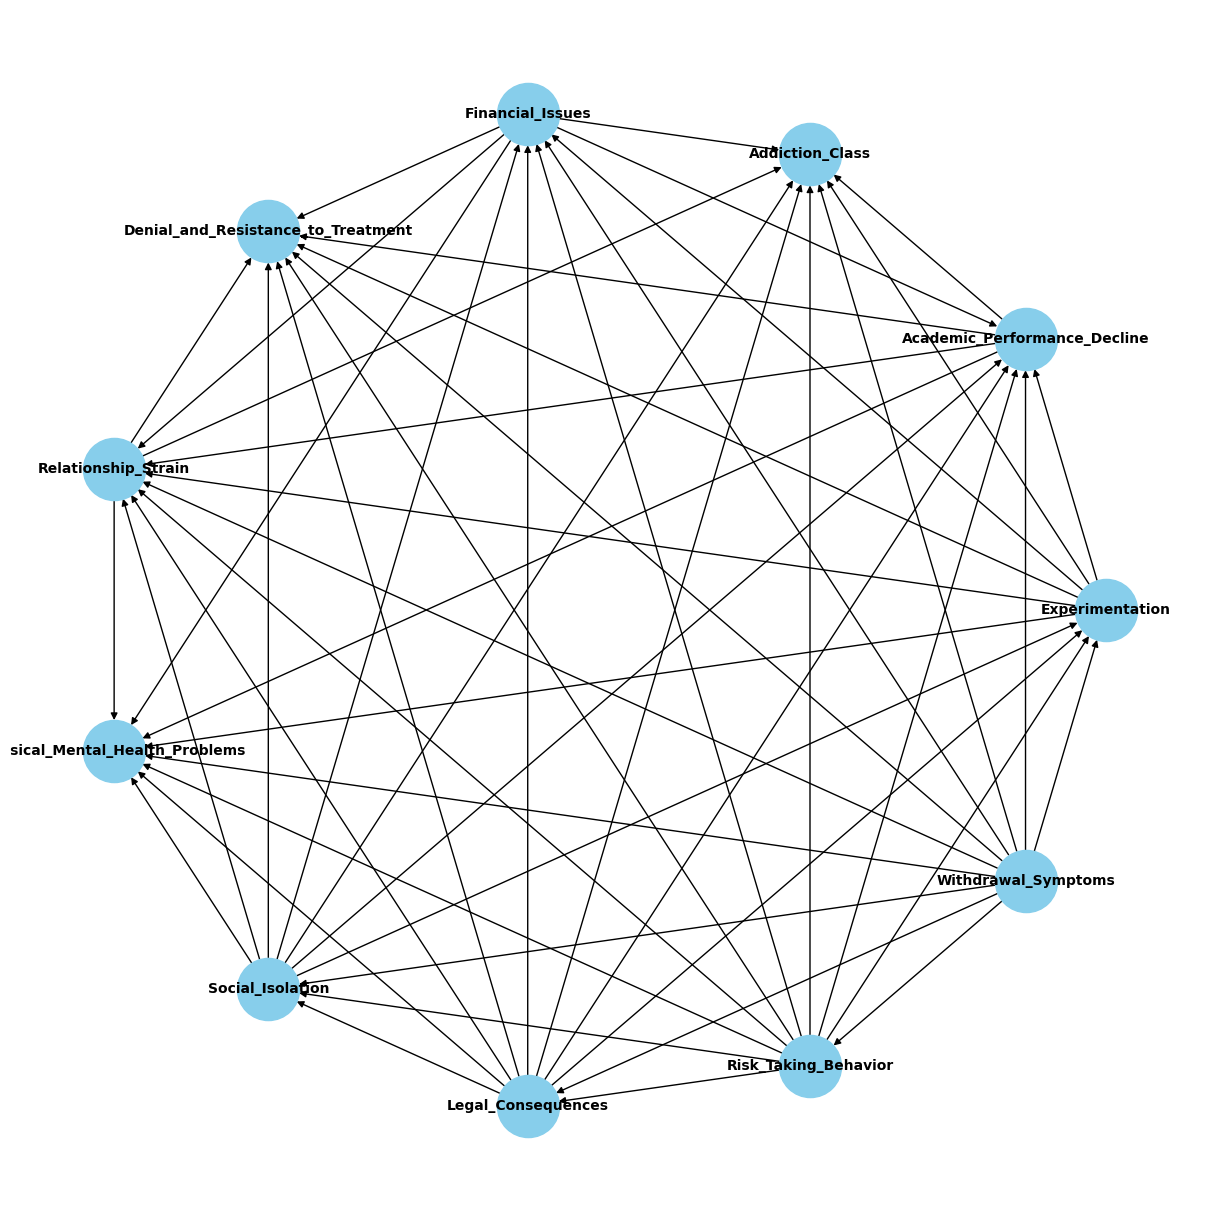

In [75]:
edges = best_model.edges()
G = nx.DiGraph(edges)
plt.figure(figsize=(12, 12))
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10, font_weight="bold", arrows=True)
plt.show()

De la red creada y graficada se puede ver que hay variables que son claramente más causa y otras consecuencia,por ejemplo la variable "Aislamiento social" y "Abstinencia" son cosas qeu sugieren que ya es adicto o que haya probado drogas, entras que los "Problemas de Salud" o "Problemas con rendimiento academico" son más consecuencia a otras variables.

In [76]:
model_inference = VariableElimination(model)

# Analizando el impacto de Experimentation
q = model_inference.query(variables=['Addiction_Class'], evidence={'Experimentation': 1})
print(q)

+--------------------+------------------------+
| Addiction_Class    |   phi(Addiction_Class) |
+====================+========================+
| Addiction_Class(0) |                 0.6996 |
+--------------------+------------------------+
| Addiction_Class(1) |                 0.3004 |
+--------------------+------------------------+


In [77]:
cpds = model.get_cpds('Addiction_Class')
print(cpds)

+------------------------------+-----+---------------------------------+
| Academic_Performance_Decline | ... | Academic_Performance_Decline(1) |
+------------------------------+-----+---------------------------------+
| Experimentation              | ... | Experimentation(1)              |
+------------------------------+-----+---------------------------------+
| Financial_Issues             | ... | Financial_Issues(1)             |
+------------------------------+-----+---------------------------------+
| Legal_Consequences           | ... | Legal_Consequences(1)           |
+------------------------------+-----+---------------------------------+
| Relationship_Strain          | ... | Relationship_Strain(1)          |
+------------------------------+-----+---------------------------------+
| Risk_Taking_Behavior         | ... | Risk_Taking_Behavior(1)         |
+------------------------------+-----+---------------------------------+
| Social_Isolation             | ... | Social_Isola

# Redes Bayesianas Balanceadas

In [78]:
df_majority = train_df[train_df['Addiction_Class'] == 0]
df_minority = train_df[train_df['Addiction_Class'] == 1]

df_majority_downsampled = resample(df_majority, 
                                   replace=False,
                                   n_samples=15072,
                                   random_state=42)

df_balanced = pd.concat([df_majority_downsampled, df_minority])

In [79]:
hc = HillClimbSearch(data=df_balanced)
best_model = hc.estimate(scoring_method=BicScore(df_balanced), show_progress=False)
for edge in best_model.edges():
    print(edge)

('Experimentation', 'Legal_Consequences')
('Experimentation', 'Denial_and_Resistance_to_Treatment')
('Experimentation', 'Addiction_Class')
('Experimentation', 'Physical_Mental_Health_Problems')
('Experimentation', 'Risk_Taking_Behavior')
('Academic_Performance_Decline', 'Experimentation')
('Academic_Performance_Decline', 'Risk_Taking_Behavior')
('Academic_Performance_Decline', 'Addiction_Class')
('Academic_Performance_Decline', 'Legal_Consequences')
('Academic_Performance_Decline', 'Physical_Mental_Health_Problems')
('Academic_Performance_Decline', 'Denial_and_Resistance_to_Treatment')
('Social_Isolation', 'Physical_Mental_Health_Problems')
('Social_Isolation', 'Addiction_Class')
('Social_Isolation', 'Academic_Performance_Decline')
('Social_Isolation', 'Legal_Consequences')
('Social_Isolation', 'Risk_Taking_Behavior')
('Social_Isolation', 'Experimentation')
('Social_Isolation', 'Financial_Issues')
('Social_Isolation', 'Relationship_Strain')
('Social_Isolation', 'Denial_and_Resistance_t

In [80]:
model = BayesianNetwork(best_model.edges())
model.fit(df_balanced, estimator=BayesianEstimator, prior_type="BDeu")
for cpd in model.get_cpds():
    print(cpd)

+------------------------------+-----+---------------------------------+
| Academic_Performance_Decline | ... | Academic_Performance_Decline(1) |
+------------------------------+-----+---------------------------------+
| Financial_Issues             | ... | Financial_Issues(1)             |
+------------------------------+-----+---------------------------------+
| Relationship_Strain          | ... | Relationship_Strain(1)          |
+------------------------------+-----+---------------------------------+
| Social_Isolation             | ... | Social_Isolation(1)             |
+------------------------------+-----+---------------------------------+
| Withdrawal_Symptoms          | ... | Withdrawal_Symptoms(1)          |
+------------------------------+-----+---------------------------------+
| Experimentation(0)           | ... | 0.5339154877655408              |
+------------------------------+-----+---------------------------------+
| Experimentation(1)           | ... | 0.4660845122

In [81]:
inference = VariableElimination(model)

evidences = [
    {'Experimentation': 1, 'Academic_Performance_Decline': 1, 'Social_Isolation': 1, 'Financial_Issues': 1, 'Legal_Consequences': 1, 'Relationship_Strain': 1, 'Risk_Taking_Behavior': 1, 'Withdrawal_Symptoms': 1},
    {'Academic_Performance_Decline': 1, 'Relationship_Strain': 1, 'Physical_Mental_Health_Problems': 1, 'Legal_Consequences': 1, 'Risk_Taking_Behavior': 1},
    {'Risk_Taking_Behavior': 1, 'Withdrawal_Symptoms': 1, 'Denial_and_Resistance_to_Treatment': 1},
    {'Physical_Mental_Health_Problems': 1, 'Legal_Consequences': 1, 'Experimentation': 1, 'Social_Isolation': 1},
    {'Experimentation': 1, 'Academic_Performance_Decline': 1, 'Social_Isolation': 1},
    {'Legal_Consequences': 1, 'Risk_Taking_Behavior': 1, 'Withdrawal_Symptoms': 1},
]

# Realizar inferencias
for i, evidence in enumerate(evidences):
    result = inference.map_query(variables=['Addiction_Class'], evidence=evidence, show_progress=False)
    print(f"Inferencia {i+1}:")
    print(f"Evidencia: {evidence}")
    print(f"Resultado: {result}")
    print()

Inferencia 1:
Evidencia: {'Experimentation': 1, 'Academic_Performance_Decline': 1, 'Social_Isolation': 1, 'Financial_Issues': 1, 'Legal_Consequences': 1, 'Relationship_Strain': 1, 'Risk_Taking_Behavior': 1, 'Withdrawal_Symptoms': 1}
Resultado: {'Addiction_Class': 0}

Inferencia 2:
Evidencia: {'Academic_Performance_Decline': 1, 'Relationship_Strain': 1, 'Physical_Mental_Health_Problems': 1, 'Legal_Consequences': 1, 'Risk_Taking_Behavior': 1}
Resultado: {'Addiction_Class': 1}

Inferencia 3:
Evidencia: {'Risk_Taking_Behavior': 1, 'Withdrawal_Symptoms': 1, 'Denial_and_Resistance_to_Treatment': 1}
Resultado: {'Addiction_Class': 0}

Inferencia 4:
Evidencia: {'Physical_Mental_Health_Problems': 1, 'Legal_Consequences': 1, 'Experimentation': 1, 'Social_Isolation': 1}
Resultado: {'Addiction_Class': 0}

Inferencia 5:
Evidencia: {'Experimentation': 1, 'Academic_Performance_Decline': 1, 'Social_Isolation': 1}
Resultado: {'Addiction_Class': 0}

Inferencia 6:
Evidencia: {'Legal_Consequences': 1, 'Ris

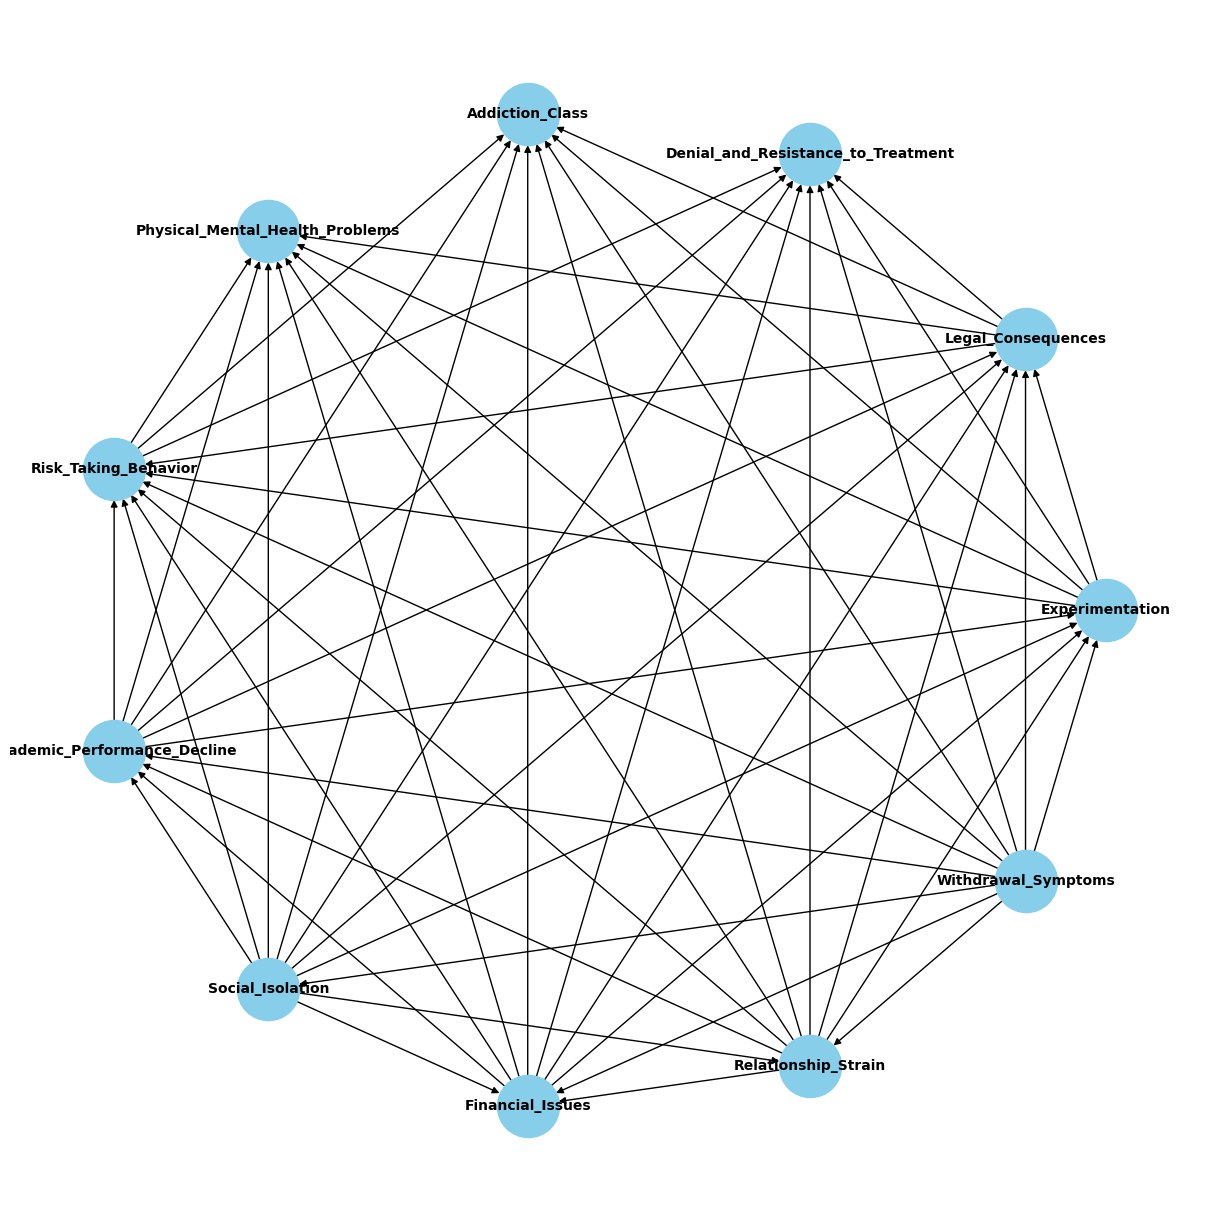

In [82]:
edges = best_model.edges()
G = nx.DiGraph(edges)
plt.figure(figsize=(12, 12))
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10, font_weight="bold", arrows=True)
plt.show()

# VAE

In [84]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [85]:
complete_df = pd.concat([train_df, test_df])

complete_df.dropna(inplace=True)
df_majority_new = complete_df[complete_df['Addiction_Class'] == 0]
df_minority_new = complete_df[complete_df['Addiction_Class'] == 1]

df_majority_downsampled_new = resample(df_majority_new,
                                      replace=False,
                                      n_samples=df_minority_new.shape[0],
                                      random_state=42)

new_balanced_df = pd.concat([df_majority_downsampled_new, df_minority_new])

In [86]:
latent_dim = 2
input_dim = new_balanced_df.shape[1]

# Encoder
encoder_inputs = tf.keras.Input(shape=(input_dim,))
x = layers.Dense(64, activation="relu")(encoder_inputs)
x = layers.Dense(32, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# Decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(32, activation="relu")(latent_inputs)
x = layers.Dense(64, activation="relu")(x)
decoder_outputs = layers.Dense(input_dim, activation="sigmoid")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │        768 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │      2,080 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         66 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         66 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,980 (11.64 KB)

 Trainable params: 2,980 (11.64 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,923 (11.42 KB)

 Trainable params: 2,923 (11.42 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss_fn = MeanSquaredError()
            reconstruction_loss = tf.reduce_mean(
                reconstruction_loss_fn(data, reconstruction)
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [88]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

In [89]:
train_tensor = tf.convert_to_tensor(new_balanced_df, dtype=tf.float32)
vae.fit(train_tensor, epochs=1, batch_size=16)

1331/1331 ━━━━━━━━━━━━━━━━━━━━ 2s 778us/step - kl_loss: 0.0052 - loss: 0.2551 - reconstruction_loss: 0.2498


In [90]:
def generate_synthetic_data(vae, num_samples):
    latent_samples = np.random.normal(size=(num_samples, latent_dim))
    generated_data = vae.decoder.predict(latent_samples)
    return generated_data

synthetic_data = generate_synthetic_data(vae, 1000)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [91]:
synthetic_df = pd.DataFrame(synthetic_data, columns=train_df.columns)
synthetic_df = synthetic_df.applymap(lambda x: 1 if x > 0.5 else 0)
synthetic_df

C:\Users\franc\AppData\Local\Temp\ipykernel_33880\643240748.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  synthetic_df = synthetic_df.applymap(lambda x: 1 if x > 0.5 else 0)


,Experimentation,Academic_Performance_Decline,Social_Isolation,Financial_Issues,Physical_Mental_Health_Problems,Legal_Consequences,Relationship_Strain,Risk_Taking_Behavior,Withdrawal_Symptoms,Denial_and_Resistance_to_Treatment,Addiction_Class
0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,1
996,0,1,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,0


In [92]:
hc = HillClimbSearch(synthetic_df)
best_model = hc.estimate(scoring_method=BicScore(synthetic_df), show_progress=False)
for edge in best_model.edges():
    print(edge)

('Academic_Performance_Decline', 'Addiction_Class')
('Academic_Performance_Decline', 'Denial_and_Resistance_to_Treatment')
('Denial_and_Resistance_to_Treatment', 'Withdrawal_Symptoms')
('Addiction_Class', 'Denial_and_Resistance_to_Treatment')


In [93]:
model = BayesianNetwork(best_model.edges())
model.fit(synthetic_df, estimator=BayesianEstimator, prior_type="BDeu")
for cpd in model.get_cpds():
    print(cpd)

+---------------------------------+-----------+
| Academic_Performance_Decline(0) | 0.918905  |
+---------------------------------+-----------+
| Academic_Performance_Decline(1) | 0.0810945 |
+---------------------------------+-----------+
+------------------------------+-----+---------------------------------+
| Academic_Performance_Decline | ... | Academic_Performance_Decline(1) |
+------------------------------+-----+---------------------------------+
| Addiction_Class(0)           | ... | 0.9846625766871165              |
+------------------------------+-----+---------------------------------+
| Addiction_Class(1)           | ... | 0.015337423312883436            |
+------------------------------+-----+---------------------------------+
+-----+---------------------------------+
| ... | Academic_Performance_Decline(1) |
+-----+---------------------------------+
| ... | Addiction_Class(1)              |
+-----+---------------------------------+
| ... | 0.5                            

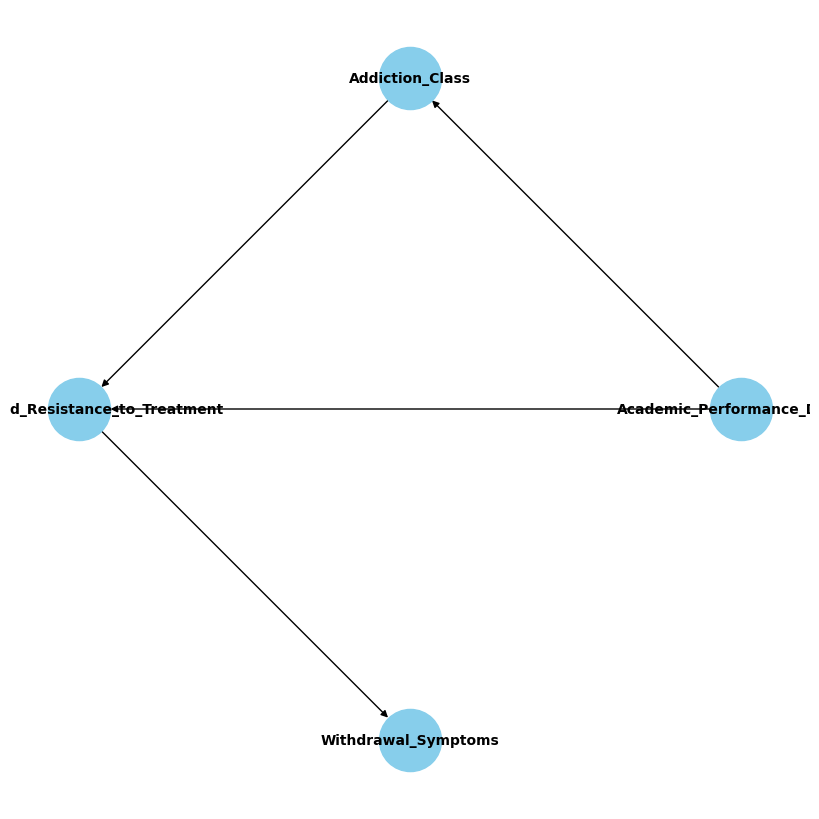

In [95]:
edges = best_model.edges()
G = nx.DiGraph(edges)
plt.figure(figsize=(8, 8))
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10, font_weight="bold", arrows=True)
plt.show()